In [1]:
import os
import shutil

import matplotlib.pyplot as plt
from mutagen.easyid3 import EasyID3
from mutagen.id3 import APIC, ID3
from pydub import AudioSegment
from pydub.playback import play
from multiprocessing import Pool
from functools import partial

In [2]:
input_folder = "../../files/tmp/"
output_folder = "../../files/tmp_normalized/"
num_workers = 15

In [3]:
def divide_list(lst, n):
    """
    Divides a list equally into n sublists.
    
    Args:
    lst: The list to be divided.
    n: The number of sublists to create.
    
    Returns:
    A list of sublists.
    """
    sublist_size = len(lst) // n
    extra = len(lst) % n
    sublists = []
    start = 0
    for i in range(n):
        end = start + sublist_size
        if i < extra:
            end += 1
        sublists.append(lst[start:end])
        start = end
    return sublists

def normalize_audio(file: str, target_dBFS):
    try:
        input_file = os.path.join(input_folder, file)
        output_file = os.path.join(output_folder, file)

            
        # Load the audio file
        audio = AudioSegment.from_file(input_file)
        if target_dBFS - 1 <= audio.dBFS and audio.dBFS <= target_dBFS + 1:
            shutil.copy2(input_file, output_file)
            print(f"No need to convert, copied: {input_file}")
            return

        # Calculate the difference in loudness
        change_in_dBFS = target_dBFS - audio.dBFS

        # Apply gain to normalize
        normalized_audio = audio.apply_gain(change_in_dBFS)
        
        original_bitrate = audio.frame_rate

        # Export normalized audio with the original bitrate
        normalized_audio.export(output_file, format="mp3", bitrate=f"{original_bitrate}k")

        # Copy metadatas
        original_tags = ID3(input_file)
        new_tags = ID3(output_file)

        # Copy tags & cover
        for tag in original_tags.keys():
            new_tags[tag] = original_tags[tag]
            if isinstance(original_tags[tag], APIC):
                new_tags.add(original_tags[tag])


        new_tags.save(output_file)
        
        print(f"Normalized: {input_file} -> {output_file}")
    except Exception as e:
        print(f"Error processing {input_file}: {e}")

def normalize_audios(files: list[str], target_dBFS):
    for f in files:
        normalize_audio(f, target_dBFS)

# Main function
def normalize_folder(input_folder, output_folder, target_dBFS):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    sublists = divide_list(os.listdir(input_folder), num_workers)
    f = partial(normalize_audios, target_dBFS=target_dBFS)
    with Pool(processes=num_workers) as pool:
        results = pool.map(f, sublists)


def get_loudness(input_folder):
    loudness_list = []
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".mp3"):
                input_file = os.path.join(root, file)
                try:
                    audio = AudioSegment.from_file(input_file)
                    loudness_list.append((input_file, audio.dBFS))
                except Exception as e:
                    print(f"Error reading {input_file}: {e}")
    return loudness_list

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-14.73006414, -14.21461998, -13.69917581, -13.18373165,
        -12.66828748, -12.15284332, -11.63739915, -11.12195499,
        -10.60651082, -10.09106666,  -9.57562249]),
 <BarContainer object of 10 artists>)

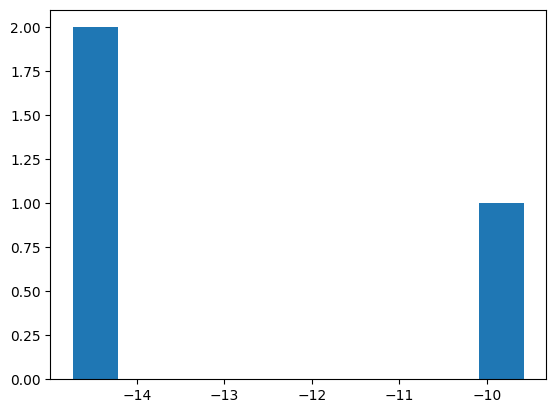

In [4]:
loudnesses = get_loudness(input_folder)
volumes = [x[1] for x in loudnesses]
plt.hist(volumes)

In [11]:
normalize_folder(input_folder, output_folder, target_dBFS=-12.0)

No need to convert, copied: ../../files/_additional/CAN GI NOI IU.mp3
No need to convert, copied: ../../files/_additional/Băng Qua Cầu Giấy.mp3
No need to convert, copied: ../../files/_additional/When You Look at Me (feat. Seachains).mp3
No need to convert, copied: ../../files/_additional/Mưa Cứ Rơi.mp3
No need to convert, copied: ../../files/_additional/Trở Về.mp3
No need to convert, copied: ../../files/_additional/Dân Chơi Sao Phải Khóc.mp3
No need to convert, copied: ../../files/_additional/Đừng.mp3
No need to convert, copied: ../../files/_additional/Nép Vào Sát Vào.mp3
No need to convert, copied: ../../files/_additional/Bước Za Đi Xa.mp3
No need to convert, copied: ../../files/_additional/Nhạc Anh (feat. Wxrdie).mp3
No need to convert, copied: ../../files/_additional/Cả 2.mp3
Normalized: ../../files/_additional/No Boundary.mp3 -> ../../files/_additional_normalized/No Boundary.mp3
Normalized: ../../files/_additional/420ChillnFree.mp3 -> ../../files/_additional_normalized/420ChillnFr

(array([ 3.,  0.,  2.,  0., 15., 13.,  0.,  1.,  3.,  3.]),
 array([-12.9243643 , -12.73979572, -12.55522714, -12.37065855,
        -12.18608997, -12.00152139, -11.8169528 , -11.63238422,
        -11.44781564, -11.26324705, -11.07867847]),
 <BarContainer object of 10 artists>)

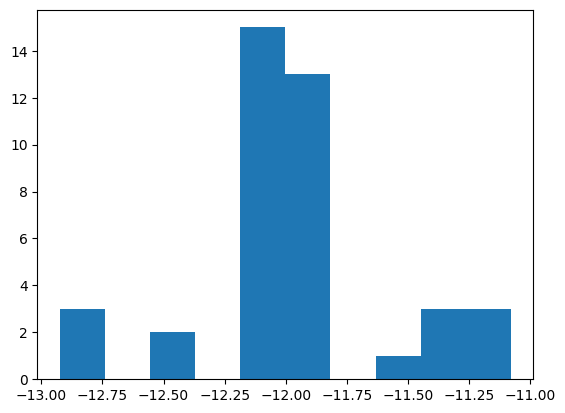

In [12]:
loudnesses = get_loudness(output_folder)
volumes = [x[1] for x in loudnesses]
plt.hist(volumes)